In [1]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.layers import GlobalAveragePooling2D, BatchNormalization
from keras.regularizers import l1_l2
from keras.layers import Dropout
import matplotlib.pyplot as plt

In [2]:
# Function to load images from a directory
def load_images_from_folder(folder, target_size=(256, 256)):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            img = cv2.resize(img, target_size)  # Resize each image to a consistent size
            images.append(img)
    return np.array(images)

# Function to extract patches from an image
def extract_patches(image, patch_size):
    patches = []
    height, width, _ = image.shape
    for i in range(0, height - patch_size + 1, patch_size):
        for j in range(0, width - patch_size + 1, patch_size):
            patch = image[i:i + patch_size, j:j + patch_size, :]
            patches.append(patch)
    return np.array(patches)

In [3]:
# Load images from the dataset
dataset_path = 'UCMerced_LandUse/Images'
categories = os.listdir(dataset_path)
X = []
y = []

for i, category in enumerate(categories):
    category_path = os.path.join(dataset_path, category)
    images = load_images_from_folder(category_path)
    for image in images:
        patches = extract_patches(image, patch_size=32)  # Adjust patch_size as needed
        X.extend(patches)
        y.extend([i] * len(patches))  # Assign a label to each patch

X = np.array(X)
y = np.array(y)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize pixel values to be between 0 and 1
X_train = X_train / 255.0
X_test = X_test / 255.0
print(X_train.shape)
print(X_test.shape)


(107520, 32, 32, 3)
(26880, 32, 32, 3)


In [4]:
# Define constants
ALPHA = 0.0001  # L1 regularization parameter
BETA = 0.0001   # L2 regularization parameter

model = Sequential()
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(32, 32, 3), kernel_regularizer=l1_l2(l1=ALPHA, l2=BETA)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l1_l2(l1=ALPHA, l2=BETA)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(256, (3, 3), activation='relu', kernel_regularizer=l1_l2(l1=ALPHA, l2=BETA)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(GlobalAveragePooling2D())
model.add(Dense(512, activation='relu', kernel_regularizer=l1_l2(l1=ALPHA, l2=BETA)))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(len(categories), activation='softmax'))

Epoch 1/10
3360/3360 [==============================] - 159s 47ms/step - loss: 3.2784 - accuracy: 0.3209 - val_loss: 2.7885 - val_accuracy: 0.3634
Epoch 2/10
3360/3360 [==============================] - 155s 46ms/step - loss: 2.5487 - accuracy: 0.4308 - val_loss: 2.6494 - val_accuracy: 0.3872
Epoch 3/10
3360/3360 [==============================] - 151s 45ms/step - loss: 2.3137 - accuracy: 0.4779 - val_loss: 2.2811 - val_accuracy: 0.4602
Epoch 4/10
3360/3360 [==============================] - 151s 45ms/step - loss: 2.1493 - accuracy: 0.5015 - val_loss: 2.2408 - val_accuracy: 0.4592
Epoch 5/10
3360/3360 [==============================] - 152s 45ms/step - loss: 2.0468 - accuracy: 0.5209 - val_loss: 2.3217 - val_accuracy: 0.4488
Epoch 6/10
3360/3360 [==============================] - 149s 44ms/step - loss: 1.9857 - accuracy: 0.5336 - val_loss: 2.2425 - val_accuracy: 0.4812
Epoch 7/10
3360/3360 [==============================] - 150s 45ms/step - loss: 1.9430 - accuracy: 0.5447 - val_loss: 1

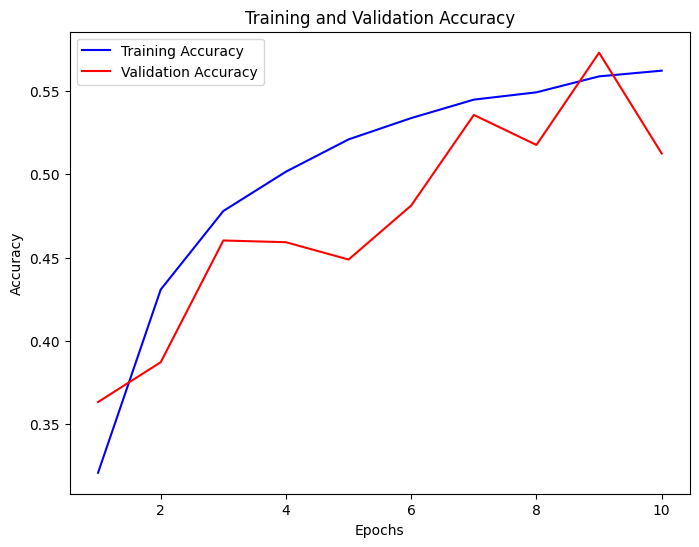

In [5]:
BATCH_SIZE = 32
EPOCHS = 10
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(X_test, y_test))

# Get training and validation accuracy values from the history object
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

# Create an array of epochs
epochs = np.arange(1, len(training_accuracy) + 1)

# Plot training and validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(epochs, training_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, validation_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()